# Convolutional neural networks

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

2023-07-24 15:53:12.672694: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 15:53:12.708747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 15:53:12.709077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:53:13.419923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Preparation

In [2]:
#organizing our data on disk
#print(os.getcwd())
os.chdir('/home/scampo/Documenti/Reborn/Jupyter/dogs-vs-cats')
#print(os.listdir())
#os.chdir('dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    for i in random.sample(glob.glob('train/cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('train/dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('train/cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('train/dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('train/cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('train/dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')


In [3]:
train_path = '/home/scampo/Documenti/Reborn/Jupyter/dogs-vs-cats/train'
valid_path = '/home/scampo/Documenti/Reborn/Jupyter/dogs-vs-cats/valid'
test_path = '/home/scampo/Documenti/Reborn/Jupyter/dogs-vs-cats/test'

put the images in format of keras generator

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

#directory iterator

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes ==2

In [6]:
imgs, labels = next(train_batches)

In [7]:
#plot images in the form of a grid with 1 row and 10 columns where images are placed

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

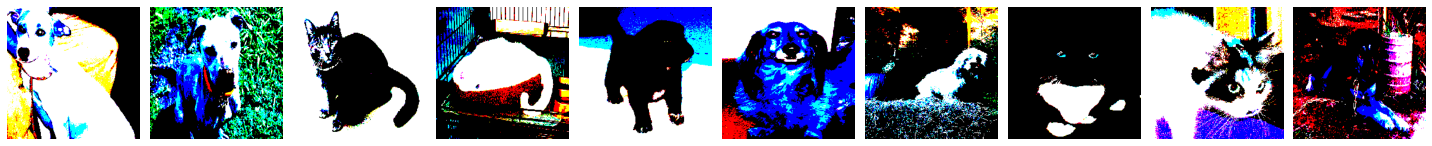

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [8]:
plotImages(imgs)
print(labels)

#what a batch training data looks like. [1,0] = cat, [0,1] = dog

## Build and train a CNN

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2), #32 filters with  a 3x3 kernel size, 0 pudding, pool cut img dimention in half
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(), #flat to 1 dimentional tensor 
    Dense(units=2, activation='softmax') #output layer , softmax gives probability for each output from the model
])

2023-07-24 15:53:15.594538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:53:15.595047: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [11]:
#training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics= ['accuracy'])
#also binary cross entrapy because only 2 output in this example

In [12]:
model.fit(x = train_batches, validation_data= valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 16s - loss: 22.1899 - accuracy: 0.5430 - val_loss: 11.0072 - val_accuracy: 0.5350 - 16s/epoch - 158ms/step
Epoch 2/10
100/100 - 15s - loss: 1.9727 - accuracy: 0.7710 - val_loss: 3.2763 - val_accuracy: 0.5900 - 15s/epoch - 150ms/step
Epoch 3/10
100/100 - 15s - loss: 0.3755 - accuracy: 0.9090 - val_loss: 2.4798 - val_accuracy: 0.6950 - 15s/epoch - 149ms/step
Epoch 4/10
100/100 - 15s - loss: 0.0938 - accuracy: 0.9690 - val_loss: 1.8095 - val_accuracy: 0.6650 - 15s/epoch - 150ms/step
Epoch 5/10
100/100 - 15s - loss: 0.0093 - accuracy: 0.9980 - val_loss: 1.8124 - val_accuracy: 0.6950 - 15s/epoch - 149ms/step
Epoch 6/10
100/100 - 15s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.9273 - val_accuracy: 0.6700 - 15s/epoch - 149ms/step
Epoch 7/10
100/100 - 15s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.8430 - val_accuracy: 0.6850 - 15s/epoch - 149ms/step
Epoch 8/10
100/100 - 15s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.8444 - val_accuracy: 0.6900 - 15s/epoch - 1

### Overfitting problem!!

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

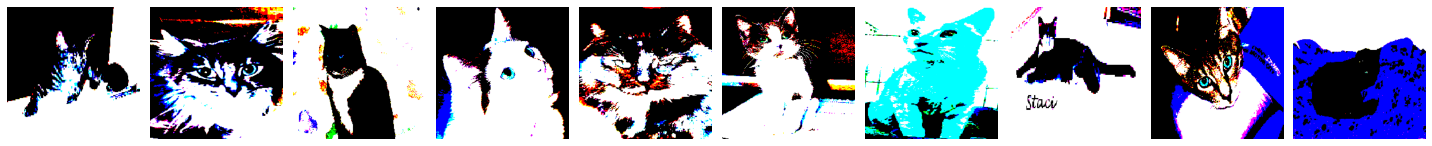

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

 because we chose to not shuffle our test set when we originally created it, the first half of the test data is all cats, and the second half is all dogs. 

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [15]:
predictions = model.predict(x = test_batches, verbose=0)

In [16]:
np.round(predictions)
#each array is a prediction for the single sample

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[31 19]
 [ 8 42]]


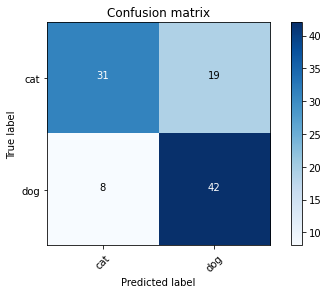

In [20]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix (cm=cm, classes = cm_plot_labels, title='Confusion matrix')

we have overfitting. => Data augentation

## Data Augmentation

Data augmentation occurs when new data is created based on modifications of existing data. 

## Build the Fine-tuned VGG16 model

In [21]:
#download the model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Build a new model

In [23]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Conver vgg16 model in a sequential object, look through every vgg16 layer exept for the last layer, add each layer into the sequential model

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [25]:
for layer in model.layers:
    layer.trainable = False
#set each layer to non trainable, freeze the trainable parameters (weights and biases) for all the layer in the model so the will not be re-trained

In [26]:
model.add(Dense(units=2, activation = 'softmax'))
#add aur own outputlayer that has 2 output classes, the only trainable layer

The last layer will be the only traning layer because vgg16 has already learn the features during its original training

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## Train and fine-tuning VGG16 model

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(x = train_batches, validation_data = valid_batches, epochs = 5, verbose = 2)

Epoch 1/5
100/100 - 58s - loss: 0.0326 - accuracy: 0.9910 - val_loss: 0.0800 - val_accuracy: 0.9650 - 58s/epoch - 583ms/step
Epoch 2/5
100/100 - 58s - loss: 0.0260 - accuracy: 0.9940 - val_loss: 0.0756 - val_accuracy: 0.9750 - 58s/epoch - 579ms/step
Epoch 3/5
100/100 - 59s - loss: 0.0209 - accuracy: 0.9960 - val_loss: 0.0767 - val_accuracy: 0.9750 - 59s/epoch - 588ms/step
Epoch 4/5
100/100 - 59s - loss: 0.0175 - accuracy: 0.9970 - val_loss: 0.0734 - val_accuracy: 0.9800 - 59s/epoch - 585ms/step
Epoch 5/5
100/100 - 58s - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.0721 - val_accuracy: 0.9750 - 58s/epoch - 579ms/step


In [34]:
assert model.history.history.get('accuracy')[-1] > 0.95

## Predict using fine-tuned VGG16 model

In [35]:
predictions = model.predict(x=test_batches, verbose=0)

In [36]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [37]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis=-1))

In [38]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 1 49]]


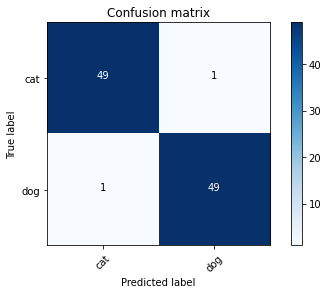

In [39]:
cm_plot_labels=['cat', 'dog']
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title='Confusion matrix')